How to use this notebook:

0. Clone this notebok

1. Go to runtime -> change runtime type -> GPU -> save(note this step is optional but recommended)

2. You can either upload all necessary files manualy from
https://drive.google.com/file/d/1QMWNo5ccAUG3Gte0I2qF3wnwaXl3hCUo/view?usp=sharing
or simply run the sniplet 1.1. In my experience the second option works much faster

3. Run the sniplets 2..9

4. If you want to train the model from scratch then run the sniplet 10

5. If you want to load the pretrained model then run the sniplet 11


In [ ]:
#0
import torch
import random
import numpy as np
import torch.nn.functional as F
import torchvision.datasets
import torch.nn.functional as F

#fix random seed to make the experiments reproducible
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
#1.1
import zipfile
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1QMWNo5ccAUG3Gte0I2qF3wnwaXl3hCUo'})
download.GetContentFile('submission.tar.gz')

In [ ]:
#1.2
!tar -xzf submission.tar.gz

In [ ]:
#2
#some constants
finalXSize = 224
finalYSize = 224
batch_size = 25

labelsTest = '/content/submission/images_family_test.txt'
labelsTrain = '/content/submission/images_family_trainval.txt'
normalisedImagesPath = '/content/submission/norm224x224/'

In [ ]:
#3
#returns two lists: labels(human readable names) and touples: (fileName, labelNumber)
def readEntries(labelsPath):
    labelN = 0
    labels = {}
    dataset = list()
    un = set()
    for line in open(labelsPath):
        i = line.index(' ')
        name, label = line[:i], line[i+1:]
        if name in un:
            print("bruh")
            break
        else:
            un.add(name)
        if label not in labels:
            labels[label] = labelN
            labelN += 1
        dataset.append((name + '.jpg', labels[label]))
    return labels, dataset

#!!!!!!  TODO ASAP: MAKE SURE THAT TRAINLABELS == TESTLABELS !!!!!! GET RID OF THIS FRAGILE CRAP
#The data set was splitted into the two parts by the Author: http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/
#It was checked that both parts are comprehensive(sets of classes are equal) in the image preprocessing script
trainLabels, trainDataset = readEntries(labelsTrain)
testLabels, testDataset = readEntries(labelsTest)
print(len(trainDataset))
print(len(testDataset))
if trainLabels != testLabels:
  raise Exception("DATA IS CORRUPTED. TEST LABELS DO NOT MATCH TRAIN LABELS")

6667
3333


In [ ]:
#4
from torch.utils.data import Dataset
from skimage import io
class AircraftFamilyDataset(Dataset):
    def __init__(self, entries, root_dir, transform):
        self.entries = entries
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.entries)
    #returns touple (ImageTensor, label)
    def __getitem__(self, index): 
        img_path = self.root_dir + self.entries[index][0]
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.entries[index][1]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [ ]:
#5
#data augmentation part
import torchvision.transforms as transforms
from torchvision.utils import save_image
#applies each transformation to each pic in the speicified order
aug_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),#flips picture upside down with probabilty 0.5
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=(0.2, 1.5), hue=(-0.5, 0.5), contrast=(0.4, 1), saturation=(0.0, 0.6)),
    transforms.ToTensor()
])
rescale_transform = transforms.Compose([
                 transforms.ToPILImage(),     
                 transforms.Resize((224, 224)),
                  transforms.ToTensor()
])
#create, train and test datasets
trainDataset = AircraftFamilyDataset(trainDataset, normalisedImagesPath, aug_transforms)
testDataset = AircraftFamilyDataset(testDataset, normalisedImagesPath, transforms.ToTensor())

In [ ]:
#6
#create dataset loader objects for each dataset(some kind of wrappers)
train_loader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=True)

In [ ]:
#7
from pynvml import *
device = torch.device('cuda:0')
#train and assess the given @net on @trainsetLoader and @testsetLoader accordingly
def train(net, trainsetLoader, testsetLoader):
    print(device)
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()#loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    #Scheduler changes learning rate of @optimizer in factor times if mean_loss doesn't decrease across @patience=7 eppochs
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=7, verbose=True)
    nvmlInit()
    for epoch in range(220):
        train_accuracy = 0.0
        pics = 0.0
        mean_loss = 0.0
        net.train()
        for batch, labels in trainsetLoader:
            optimizer.zero_grad()    
            pics += batch.shape[0]
            batch = batch.to(device)
            labels = labels.to(device)
            preds = net.forward(batch)
            train_accuracy += (preds.argmax(dim=1) == labels).float().sum().data.cpu()

            loss_value = loss(preds, labels)
            mean_loss += loss_value.item()
            loss_value.backward()
            optimizer.step()
        mean_loss /= len(trainsetLoader.dataset)
        scheduler.step(mean_loss)
        train_accuracy /= pics
        accuracy = 0.0
        pics = 0.0
        net.eval()
        for X_batch, y_batch in testsetLoader:
            pics += X_batch.shape[0]
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            test_preds = net.forward(X_batch)
            test_accuracy = (test_preds.argmax(dim=1) == y_batch).float().sum().data.cpu()
            accuracy += test_accuracy
        accuracy = accuracy / pics
        print(epoch, accuracy, train_accuracy, mean_loss)
        if accuracy >= 0.8:#stop training right away, cuz its too good to be true or u got lucky once in a lifetime
            break

def calcAccuracy(loader, net):
    net.eval()
    pics = 1.0e-20#to avoid zero dominator
    accuracy = 0.0
    for X_batch, y_batch in loader:
        pics += X_batch.shape[0]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        test_preds = net.forward(X_batch)
        accuracy += (test_preds.argmax(dim=1) == y_batch).float().sum().data.cpu()
    accuracy /= pics
    return accuracy


In [ ]:
#8
import torch.nn.functional as F

#my ResNet implementation
class baseBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dim_changer=None):
        super(baseBlock, self).__init__()
        self.expansion = 4
        self.dim_changer = dim_changer
        self.dropout = torch.nn.Dropout(p=0.1)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)#todo: calculate padding in such way that doesn't change the size of the input tensor
        self.bn1 = torch.nn.BatchNorm2d(out_channels) 
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.conv3 = torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(out_channels * self.expansion)
        self.act = torch.nn.functional.relu

    def forward(self, x):
        res = self.act(self.dropout(self.bn1(self.conv1(x))))
        res = self.act(self.dropout(self.bn2(self.conv2(res))))
        res = self.act(self.dropout(self.bn3(self.conv3(res))))
        if self.dim_changer is not None:
            x = self.dim_changer(x)
        res = self.act(x + res)
        return res

class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_of_classes):
        super(ResNet, self).__init__()
        self.in_chan = 64
        self.conv1 = torch.nn.Conv2d(3, 64, stride=2, kernel_size=7, padding=3, bias=False)
        self.bn = torch.nn.BatchNorm2d(64)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.act = torch.nn.functional.relu
        self.maxPool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.layer1 = self.buildBlock(block, layers[0], 64, 2)
        self.layer2 = self.buildBlock(block, layers[1], 128, 2)
        self.layer3 = self.buildBlock(block, layers[2], 256, 2)
        self.layer4 = self.buildBlock(block, layers[3], 512, 2)
        self.avgPool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * 4, num_of_classes)
    
    def forward(self, x):
        x = self.maxPool(self.act(self.dropout(self.bn(self.conv1(x)))))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgPool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


    def buildBlock(self, block, layers, out_chan, stride):
      dim_changer = None
      if stride != 1 or self.in_chan != out_chan * 4:
        dim_changer = torch.nn.Sequential(torch.nn.Conv2d(self.in_chan, out_chan * 4, stride=stride, kernel_size=1), torch.nn.BatchNorm2d(out_chan * 4))
      res = []
      res.append(block(self.in_chan, out_chan, stride=stride, dim_changer=dim_changer))
      self.in_chan = out_chan * 4
      for i in range(1, layers - 1):
        res.append(block(self.in_chan, out_chan))
      res = torch.nn.Sequential(*res)
      return res

In [ ]:
#9
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from torch.jit.annotations import List

#My Dense network implementation
#some ideas were taken from the official repository, but the most was written from scratch in order to understand DenseNet in more detailed way
class Transition(nn.Sequential):
  def __init__(self, num_in_features, num_out_features):
    super(Transition, self).__init__()
    self.add_module('norm', nn.BatchNorm2d(num_in_features))
    self.add_module('relu', nn.ReLU(inplace=True))
    self.add_module('conv', nn.Conv2d(num_in_features, num_out_features, kernel_size=1, stride=1, bias=False))
    self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class Layer(torch.nn.Module):
  def __init__(self, num_inp_features, g_rate, bn_size, drop_rate):
    super(Layer, self).__init__()
    self.norm1 = nn.BatchNorm2d(num_inp_features)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(num_inp_features, bn_size *
                                        g_rate, kernel_size=1, stride=1,
                                        bias=False)
    self.norm2 = nn.BatchNorm2d(bn_size * g_rate)
    self.relu2 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(bn_size * g_rate, g_rate,
                                        kernel_size=3, stride=1, padding=1,
                                        bias=False)
    self.drop_rate = float(drop_rate)

  def bn_function(self, inputs):
    concated = torch.cat(inputs, 1)
    out = self.conv1(self.relu1(self.norm1(concated)))
    return out

  def forward(self, input):
    if isinstance(input, Tensor):
        prev_features = [input]
    else:
        prev_features = input

    bottleneck_output = self.bn_function(prev_features)
    new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
    if self.drop_rate > 0:
        new_features = F.dropout(new_features, p=self.drop_rate,
                                  training=self.training)
    return new_features

class DenseBlock(nn.ModuleDict):

  def __init__(self, num_layers, num_in_features, b_size, g_rate, drop_rate):
    super(DenseBlock, self).__init__()
    for i in range(num_layers):
      layer = Layer(num_in_features + i * g_rate,
                    g_rate=g_rate,
                    bn_size=b_size,
                    drop_rate=drop_rate)
      self.add_module('denselayer%d' % (i + 1), layer)
  def forward(self, init_features):
      features = [init_features]
      for name, layer in self.items():
        new_feat = layer(features)
        features.append(new_feat)
      return torch.cat(features, 1)
  
class DenseNet(nn.Module):
  def __init__(self, n_classes, g_rate=32, block_conf=(6, 12, 24, 16), num_init_features=64, bn_size=4,
               drop_rate=0):
    super(DenseNet, self).__init__()
    self.features = nn.Sequential(OrderedDict([
      ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                          padding=3, bias=False)),
      ('norm0', nn.BatchNorm2d(num_init_features)),
      ('relu0', nn.ReLU(inplace=True)),
      ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))
    nf = num_init_features#number of features
    lastI = len(block_conf) - 1
    for i, num_layers in enumerate(block_conf):
      block = DenseBlock(
          num_layers=num_layers,
          num_in_features = nf,
          b_size=bn_size,
          g_rate=g_rate,
          drop_rate=drop_rate
      )
      self.features.add_module('denseblock%d' % (i + 1), block)
      nf = nf + num_layers * g_rate
      if i != lastI:
        transition = Transition(num_in_features=nf, num_out_features=nf // 2)
        self.features.add_module('transition%d' % (i + 1), transition)
        nf = nf // 2
    self.features.add_module('norm5', nn.BatchNorm2d(nf))

    # Linear layer
    self.classifier = nn.Linear(nf, n_classes)

    # Official init from torch repository.
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.constant_(m.bias, 0)
  def forward(self, x):
    out = self.features(x)
    out = F.relu(out, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    return out

# New section

In [ ]:
#10 
#Train network from scratch
#del net # uncomment folowing lines if you ran into memory limmit issue
# torch.cuda.empty_cache()
# import gc
# gc.collect()
print(trainLabels)
layers=[6, 12, 24, 16]
net = DenseNet(n_classes=len(trainLabels), block_conf=layers, drop_rate=0.2)
train(net, train_loader, test_loader)
torch.save(net.state_dict(), '/content/drive/My Drive/Colab Notebooks/denseNetForVarientsBest.pth')

cuda:0
0 tensor(0.7690) tensor(1.) 3.0353997090844547e-05
1 tensor(0.7756) tensor(1.) 3.4840432483241235e-05
2 tensor(0.7720) tensor(0.9999) 3.2104601218482235e-05
3 tensor(0.7711) tensor(0.9999) 4.3690540788537835e-05
4 tensor(0.7747) tensor(1.) 3.2581853996051764e-05
5 tensor(0.7711) tensor(0.9999) 4.017463017312289e-05
6 tensor(0.7660) tensor(0.9999) 3.855958029158079e-05
7 tensor(0.7663) tensor(1.) 3.26551225220592e-05


In [ ]:
#11
#loads trained model
nnPath = '/content/submission/denseNetForVarientsWhole.pth'

net = DenseNet(len(trainLabels))
net.load_state_dict(torch.load(nnPath))
net = net.to(device)


In [ ]:
#11.5
#check net on the training set
print(calcAccuracy(test_loader, net))

['Boeing 707', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757', 'Boeing 767', 'Boeing 777', 'A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'Dash 8', 'DR-400', 'Dornier 328', 'Embraer E-Jet', 'EMB-120', 'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16', 'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50', 'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'King Air', 'PA-28', 'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134', 'Tu-154', 'Yak-42']


['Boeing 707', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757', 'Boeing 767', 'Boeing 777', 'A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'Dash 8', 'DR-400', 'Dornier 328', 'Embraer E-Jet', 'EMB-120', 'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16', 'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50', 'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'King Air', 'PA-28', 'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134', 'Tu-154', 'Yak-42']
Enter jpg image url: https://i.ibb.co/Y7wTFwT/mai5.jpg
torch.Size([1, 3, 224, 224])
Boeing 717


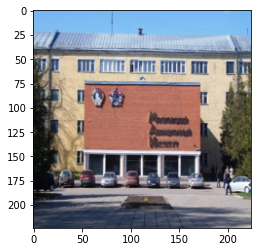

In [ ]:
#12
#downloads given image from the internet and classsifies it
import requests
import random
import time
import matplotlib.pyplot as plt

labels = list(map(lambda a: a[:-1], trainLabels.keys()))
print(labels)

url = input("Enter jpg image url: ")
r = requests.get(url, allow_redirects=True)
#t = r.headers.get('content-type')
name = str(time.time())
open(name, 'wb').write(r.content)

image = io.imread(name)
if len(image.shape)<3:
  image = grey2rgb(image)
image = rescale_transform(image)
inp_tensor = image.unsqueeze(0)
print(inp_tensor.shape)
net.eval()
inp_tensor = inp_tensor.to(device)
predProb = net.forward(inp_tensor)
predictedLabel = predProb.argmax(dim=1)

print(labels[predictedLabel[0].item()])

plt.imshow(image.permute(1, 2, 0))
plt.show()